# MNIST with Data Augmentation

## 载入套件

In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np

## 设定参数

In [2]:
# 设定参数
PATH_DATASETS = "" # 预设路径
BATCH_SIZE = 1000  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 定义资料增补函数

In [3]:
image_width = 28
train_transforms = transforms.Compose([
    #transforms.ColorJitter(), # 亮度、饱和度、对比资料增补
    # 裁切部分图像，再调整图像尺寸
    transforms.RandomResizedCrop(image_width, scale=(0.8, 1.0)), 
    transforms.RandomRotation(degrees=(-10, 10)), # 旋转 10 度
    #transforms.RandomHorizontalFlip(), # 水平翻转
    #transforms.RandomAffine(10), # 仿射
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

test_transforms = transforms.Compose([
    transforms.Resize((image_width, image_width)), # 调整图像尺寸
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

## 步骤1：载入 MNIST 手写阿拉伯数字资料

In [4]:
# 下载 MNIST 手写阿拉伯数字 训练资料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=train_transforms)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# 下载测试资料
test_ds = MNIST(PATH_DATASETS, train=False, download=True,  
                 transform=test_transforms)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# 训练/测试资料的维度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## 步骤2：资料清理，此步骤无需进行

## 步骤3：特征工程，此步骤无需进行

## 步骤4：资料分割，此步骤无需进行，载入MNIST资料时，已经切割好了

## 步骤5：建立模型结构

In [5]:
# Conv2d 参数： in-channel, out-channel, kernel size, Stride, Padding
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

## 步骤6：结合训练资料及模型，进行模型训练

In [6]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    loss_list = []    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')
    return loss_list

In [7]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # print(data.shape)
            # print(target)
            if type(data) == tuple:
                data = torch.FloatTensor(data)
            if type(target) == tuple:
                target = torch.Tensor(target)
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            _, predicted = torch.max(output.data, 1)
            # print(predicted)
            correct += (predicted == target).sum().item()

    # 平均损失
    test_loss /= len(test_loader.dataset) 
    # 显示测试结果
    data_count = len(test_loader.dataset)
    percentage = 100. * correct / data_count 
    print(f'准确率: {correct}/{data_count} ({percentage:.2f}%)')

In [8]:
epochs = 5
lr=1

# 建立模型
model = Net().to(device)

# 损失
criterion = F.nll_loss # nn.CrossEntropyLoss()

# 设定优化器(optimizer)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

loss_list = []
for epoch in range(1, epochs + 1):
    loss_list += train(model, device, train_loader, criterion, optimizer, epoch)
    #test(model, device, test_loader)
    optimizer.step()

Epoch 1: [10000 / 60000] (17 %)  Loss: 1.905932
Epoch 1: [20000 / 60000] (33 %)  Loss: 0.823097
Epoch 1: [30000 / 60000] (50 %)  Loss: 0.602738
Epoch 1: [40000 / 60000] (67 %)  Loss: 0.445632
Epoch 1: [50000 / 60000] (83 %)  Loss: 0.422776
Epoch 1: [60000 / 60000] (100 %)  Loss: 0.350808
Epoch 2: [10000 / 60000] (17 %)  Loss: 0.291289
Epoch 2: [20000 / 60000] (33 %)  Loss: 0.363400
Epoch 2: [30000 / 60000] (50 %)  Loss: 0.264314
Epoch 2: [40000 / 60000] (67 %)  Loss: 0.250480
Epoch 2: [50000 / 60000] (83 %)  Loss: 0.253205
Epoch 2: [60000 / 60000] (100 %)  Loss: 0.235315
Epoch 3: [10000 / 60000] (17 %)  Loss: 0.223402
Epoch 3: [20000 / 60000] (33 %)  Loss: 0.223477
Epoch 3: [30000 / 60000] (50 %)  Loss: 0.259600
Epoch 3: [40000 / 60000] (67 %)  Loss: 0.182856
Epoch 3: [50000 / 60000] (83 %)  Loss: 0.270474
Epoch 3: [60000 / 60000] (100 %)  Loss: 0.182969
Epoch 4: [10000 / 60000] (17 %)  Loss: 0.179848
Epoch 4: [20000 / 60000] (33 %)  Loss: 0.159400
Epoch 4: [30000 / 60000] (50 %)  Loss

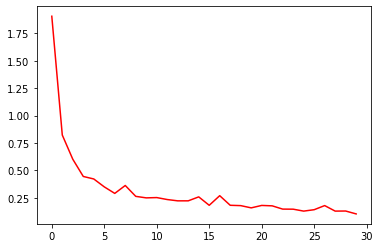

In [9]:
# 对训练过程的损失绘图
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步骤7：评分(Score Model)

In [10]:
test(model, device, test_loader)

准确率: 9839/10000 (98.39%)


In [11]:
# 实际预测 20 笔资料
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

# 比对
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4


## 步骤8：评估，暂不进行

## 步骤9：模型布署

## 步骤10：新资料预测

### 方法1：使用 Pillow 套件

In [12]:
# 显示图像
import matplotlib.pyplot as plt

def imshow(X):
    # 绘制点阵图，cmap='gray':灰阶
    plt.imshow(X.reshape(28,28), cmap='gray')

    # 隐藏刻度
    plt.axis('off') 

    # 显示图形
    plt.show() 

In [13]:
# 使用PIL读取档案，像素介于[0, 255]
import PIL.Image as Image

data_shape = data.shape

for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = Image.open(uploaded_file).convert('L')

    # 缩为 (28, 28) 大小的影像
    image_resized = image1.resize(tuple(data_shape)[2:])
    X1 = np.array(image_resized).reshape([1]+list(data_shape)[1:])
    # 反转颜色，颜色0为白色，与 RGB 色码不同，它的 0 为黑色
    X1 = 1.0-(X1/255)

    # 图像转换
    X1 = (X1 - 0.1307) / 0.3081  
    
    # 显示转换后的图像
    # imshow(X1)
    
    X1 = torch.FloatTensor(X1).to(device)
    
    # 预测
    output = model(X1)
    # print(output, '\n')
    _, predicted = torch.max(output.data, 1)
    print(f'actual/prediction: {i} {predicted.item()}')

actual/prediction: 0 0
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 3
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 3
actual/prediction: 8 8
actual/prediction: 9 8


### 方法2：使用 skimage 套件

In [14]:
# 使用 skimage 读取档案，像素介于[0, 1]
from skimage import io
from skimage.transform import resize

# 读取影像并转为单色
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # 缩为 (28, 28) 大小的影像
    image_resized = resize(image1, tuple(data_shape)[2:], anti_aliasing=True)    
    X1 = image_resized.reshape([1]+list(data_shape)[1:]) 
    # 反转颜色，颜色0为白色，与 RGB 色码不同，它的 0 为黑色
    X1 = 1.0-X1
    
    # 图像转换
    X1 = (X1 - 0.1307) / 0.3081  

    # 显示转换后的图像
    # imshow(X1)
    
    X1 = torch.FloatTensor(X1).to(device)
    
    # 预测
    output = model(X1)
    _, predicted = torch.max(output.data, 1)
    print(f'actual/prediction: {i} {predicted.item()}')

actual/prediction: 0 0
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 3
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 3
actual/prediction: 8 8
actual/prediction: 9 9


### 方法3：使用自订资料集

In [15]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None
                 , to_gray=False, size=28):
        self.img_labels = [file_name for file_name in os.listdir(img_dir)]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.to_gray = to_gray
        self.size = size

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 组合档案完整路径
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        # 读取图档
        mode = 'L' if self.to_gray else 'RGB'
        image = Image.open(img_path, mode='r').convert(mode)
        image = Image.fromarray(1.0-(np.array(image)/255))

        # print(image.shape)
        # 去除副档名
        label = int(self.img_labels[idx].split('.')[0])
        
        # 转换
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

### 预测

In [16]:
ds = CustomImageDataset('./myDigits', to_gray=True, transform=test_transforms)
data_loader = torch.utils.data.DataLoader(ds, batch_size=10,shuffle=False)

test(model, device, data_loader)

准确率: 9/10 (90.00%)


### 验证

In [17]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in data_loader:
        print(target)
        data, target = data.to(device), target.to(device)
        
        # 预测
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        print(predicted)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 3, 8, 9], device='cuda:0')


In [18]:
# 模型存档
torch.save(model, 'cnn_augmentation_model.pt')